In [7]:
%matplotlib inline
from pathlib import Path

import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import MiniBatchKMeans

In [8]:
data_path = Path('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/')

image_paths_list = sorted(data_path.glob('*.jpg'))
len(image_paths_list)

17

In [9]:
image_paths_list[:3], image_paths_list[-3:]

([PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_001.jpg'),
  PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_002.jpg'),
  PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_003.jpg')],
 [PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_015.jpg'),
  PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/bennett_pack-film_-001.jpg'),
  PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/bennett_pack-film_-002.jpg')])

In [41]:
# what if we loaded the LCC file to use as a mask?
lcc_path = image_paths_list[-2]
image_path = image_paths_list[1]
lcc_path, image_path

(PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/bennett_pack-film_-001.jpg'),
 PosixPath('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_002.jpg'))

In [42]:
lcc = cv2.imread(str(lcc_path))
image = cv2.imread(str(image_path))

In [43]:
lcc_gray = cv2.cvtColor(lcc, cv2.COLOR_BGR2GRAY)
lcc_blurred = cv2.GaussianBlur(lcc_gray, (21, 21), 5)
lcc_blurred.min()

224

In [44]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 5)
image_blurred = cv2.bilateralFilter(image_gray, 21, 21, 21)
image_blurred.min()

60

In [45]:
image_gray

array([[221, 221, 222, ..., 222, 222, 222],
       [221, 221, 222, ..., 221, 221, 221],
       [221, 221, 222, ..., 221, 221, 221],
       ...,
       [224, 224, 224, ..., 224, 224, 224],
       [224, 224, 224, ..., 224, 224, 224],
       [224, 224, 224, ..., 223, 223, 223]], dtype=uint8)

In [69]:
image_gray.shape

(800, 1067)

In [46]:
image_blurred.max()

226

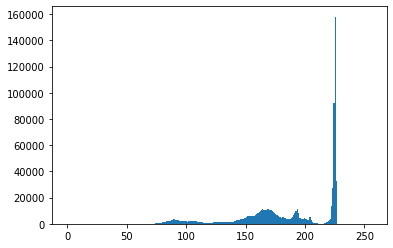

In [47]:
plt.hist(image_blurred.ravel(),256,[0,256]); plt.show()

In [48]:
image_blurred_bgr = cv2.cvtColor(image_blurred, cv2.COLOR_GRAY2BGR)
image_blurred_lab = cv2.cvtColor(image_blurred_bgr, cv2.COLOR_BGR2LAB)

In [49]:
(h, w) = image_blurred_lab.shape[:2]
reshaped = image_blurred_lab.reshape((image_blurred_lab.shape[0] * image_blurred_lab.shape[1], 3))

In [50]:
# apply k-means using the specified number of clusters and
# then create the quantized reshaped based on the predictions
clt = MiniBatchKMeans(n_clusters = 5)
labels = clt.fit_predict(reshaped)
quant = clt.cluster_centers_.astype("uint8")[labels]
 
# reshape the feature vectors to reshapeds
quant = quant.reshape((h, w, 3))
reshaped = reshaped.reshape((h, w, 3))
 
# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(reshaped, cv2.COLOR_LAB2BGR)
 
# display the reshapeds and wait for a keypress
# cv2.imshow("quantized", np.hstack([reshaped, quant]))
# cv2.waitKey(0)

In [51]:
quant

array([[[224, 224, 224],
        [224, 224, 224],
        [224, 224, 224],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [224, 224, 224]],

       [[224, 224, 224],
        [224, 224, 224],
        [224, 224, 224],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [224, 224, 224]],

       [[224, 224, 224],
        [224, 224, 224],
        [224, 224, 224],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [224, 224, 224]],

       ...,

       [[224, 224, 224],
        [224, 224, 224],
        [224, 224, 224],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [224, 224, 224]],

       [[224, 224, 224],
        [224, 224, 224],
        [224, 224, 224],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [224, 224, 224]],

       [[224, 224, 224],
        [224, 224, 224],
        [224, 224, 224],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [224, 224, 224]]

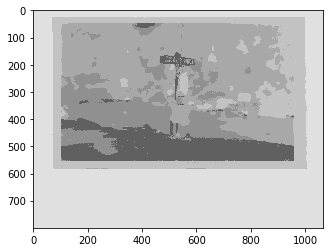

In [52]:
plt.imshow(quant, cmap='gray')

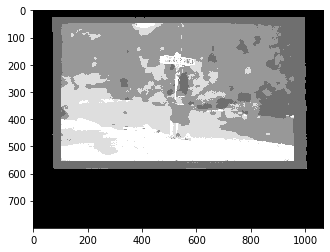

In [53]:
# threshold
gray = cv2.cvtColor(quant, cv2.COLOR_BGR2GRAY)
new = cv2.equalizeHist(gray)
new = np.invert(new)
plt.imshow(new, cmap='gray')

In [54]:
np.where(new > 0)

(array([ 24,  24,  25, ..., 584, 584, 584]),
 array([994, 995, 963, ..., 209, 210, 216]))

In [67]:
unique_values = np.unique(new)
print(unique_values)
print(unique_values[1])
threshold_value = (unique_values[1] - 1)
print(f'threshold value is {threshold_value}')

[  0 111 152 222 255]
111
threshold value is 110


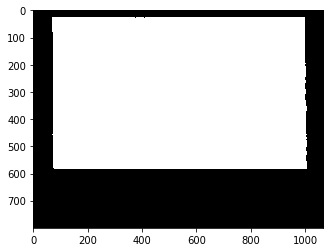

In [68]:
_, thresh = cv2.threshold(new, threshold_value, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

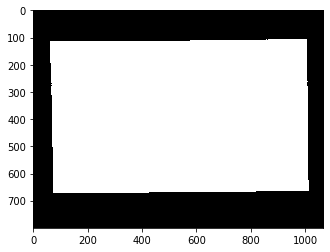

In [40]:
# apply Otsu's automatic thresholding
(T, thresh) = cv2.threshold(image_blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

In [ ]:
plt.hist(reshaped.ravel(),256,[0,256]); plt.show()

In [ ]:
np.mean(image_blurred), np.median(image_blurred)

In [ ]:
np.mean(lcc_blurred), np.median(lcc_blurred)

In [ ]:
new = cv2.subtract(lcc_gray, image_blurred)

In [ ]:
plt.hist(new.ravel(),256,[0,256]); plt.show()

In [ ]:
(T, thresh) = cv2.threshold(new, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

In [ ]:
T

In [ ]:
plt.imshow(thresh)

In [ ]:
# set a manual threshold
_, thresh = cv2.threshold(new, 15, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh)

In [ ]:
for image_path in image_paths_list:
    print(image_path.stem)
    !python autocrop.py {str(image_path)}